In [1]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator
from langchain.messages import SystemMessage
from langchain.messages import ToolMessage
from typing import Literal

c:\Users\jw160\project\RAG\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [2]:
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain.messages import HumanMessage, AIMessage

In [3]:
# 샘플 문서 데이터
documents = [
    "인공지능(AI)은 컴퓨터 시스템이 인간의 지능을 모방하여 학습하고 추론할 수 있도록 하는 기술입니다.",
    "머신러닝은 AI의 한 분야로, 데이터로부터 패턴을 학습하여 예측이나 분류를 수행합니다.",
    "딥러닝은 신경망을 사용하여 복잡한 패턴을 학습하는 머신러닝의 하위 분야입니다.",
    "자연어처리(NLP)는 인간의 언어를 컴퓨터가 이해하고 처리할 수 있도록 하는 AI 기술입니다.",
    "컴퓨터 비전은 이미지나 비디오에서 의미 있는 정보를 추출하는 AI 분야입니다."
]

# Document 객체로 변환
docs = [Document(page_content=text) for text in documents]

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=50
)
splits = text_splitter.split_documents(docs)

In [4]:
embeddings = HuggingFaceEndpointEmbeddings(client="http://127.0.0.1:8080/")
vectorstore = InMemoryVectorStore.from_documents(splits, embeddings)

In [5]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

In [6]:
model = init_chat_model(
    "phi3-mini",
    model_provider="ollama",
    base_url="http://localhost:11434",
    temperature=0,
    max_tokens=50,
    model_kwargs={
    "num_predict": 50  # Ollama 전용 파라미터
    }
)


In [7]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)


In [18]:
print(model_with_tools)

bound=ChatOllama(model='phi3-mini', temperature=0.0, base_url='http://localhost:11434') kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]} config={} config_factories=[]


In [8]:
def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a friendly helper. Respond to users' questions in a friendly manner."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [9]:
def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [10]:
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

In [11]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

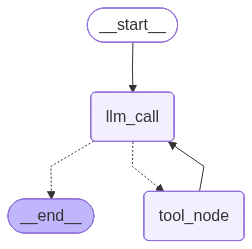

In [12]:
from IPython.display import Image, display
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


In [13]:
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

ResponseError: registry.ollama.ai/library/phi3-mini:latest does not support tools (status code: 400)

In [14]:
graph = StateGraph(MessagesState)
graph.add_node(llm_call)
graph.add_edge(START, "llm_call")
graph.add_edge("llm_call", END)
graph = graph.compile()

In [16]:
graph.invoke({"messages": [{"role": "user", "content": "1 더하기 1은?"}]})

ResponseError: registry.ollama.ai/library/phi3-mini:latest does not support tools (status code: 400)

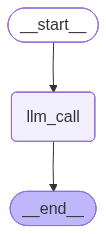

In [ ]:
# from IPython.display import Image, display
# display(Image(graph.get_graph(xray=True).draw_mermaid_png()))